### Data analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from upsetplot import from_contents
from upsetplot import UpSet
from tqdm import tqdm
import os
from functools import reduce

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from rdkit import RDLogger  
RDLogger.DisableLog('rdApp.*')    

### Training dataset derived from "Liability predictor"

In [4]:
map_keys = {"fluc": "FI", "nluc": "NI", "redox": "RR", "thiol": "TR"}

In [5]:
# Load the training data.
train_dataset = {}
for i in tqdm(os.listdir("../../data/train")):
    fname = i.split(".")[0]
    df = pd.read_csv(f"../../data/train/{i}")
    train_dataset[map_keys[fname]] = df

# Load the test data.
test_dataset = {}
for i in tqdm(os.listdir("../../data/test")):
    if i.endswith(".csv"):
        fname = i.split(".")[0]
        df = pd.read_csv(f"../../data/test/{i}")
        test_dataset[map_keys[fname]] = df

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 710.30it/s]


In [6]:
test_dataset["FI"]

,smiles,label
0,CCn1cc(C2=NOC(C(=O)Nc3c(C)n(C)n(-c4ccccc4)c3=O...,0
1,O=C(NCCCNc1nc(Nc2cccc(CN3CCOCC3)c2)ncc1C1CC1)C...,0
2,O=C1C(CC[C@H](O)c2ccc(F)cc2)[C@@H](c2ccc(O)cc2...,0
3,CC(=O)O[C@@H]1C=C2[C@H](CC[C@@]3(C)[C@@]2(O)CC...,0
4,C=C1CCC2C(C)(C)C(O)CCC2(C)C1CCC(C)CCOC(=O)CCC(...,0
...,...,...
976,O=C(NC(Cc1ccccc1)C(=O)O)c1sc2cc(F)ccc2c1Cl,0
977,CC(=O)NC(Cc1ccc(O)cc1)C(=O)NC(CCCN=C(N)N)C(=O)...,0
978,N#Cc1ccc(COC[C@H]2O[C@@H](n3c(NCc4ccc(Cl)c(Cl)...,0
979,CC(C)CCN1c2nc(Nc3cc(F)c(O)c(F)c3)ncc2N(C)C(=N)C1C,0


In [7]:
# Merge dataframes.
train_frames = []
for k, v in train_dataset.items():
    v.columns = ["smiles", k]
    train_frames.append(v)
train_merged = reduce(lambda  left,right: pd.merge(left,right,on=['smiles'],
                                            how='outer'), train_frames)

test_frames = []
for k, v in test_dataset.items():
    v.columns = ["smiles", k]
    test_frames.append(v)
test_merged = reduce(lambda  left,right: pd.merge(left,right,on=['smiles'],
                                            how='outer'), test_frames)

In [8]:
# Sanity check.
train_merged.drop("smiles", axis=1, inplace=True)
test_merged.drop("smiles", axis=1, inplace=True)

#### Check class distribution

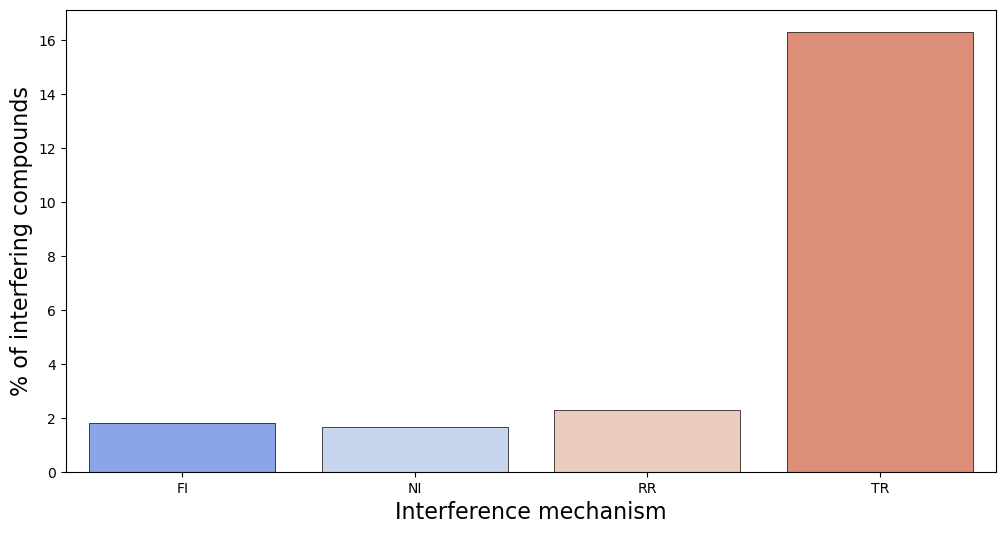

In [9]:
plt.figure(figsize=(12, 6))
sns.barplot(x=train_merged.columns, y=(train_merged.sum(axis=0) / len(train_merged)) * 100, palette="coolwarm", edgecolor="k", linewidth=0.5)
plt.xlabel("Interference mechanism", fontdict={"size": 16})
plt.ylabel("% of interfering compounds", fontdict={"size": 16});

#### Check compounds overlap

Check number of overlapping positives for each assay interference mechanism.

100%|██████████| 4/4 [00:00<00:00, 7917.52it/s]


Text(0.5, 1.0, '# of interfering \n compounds')

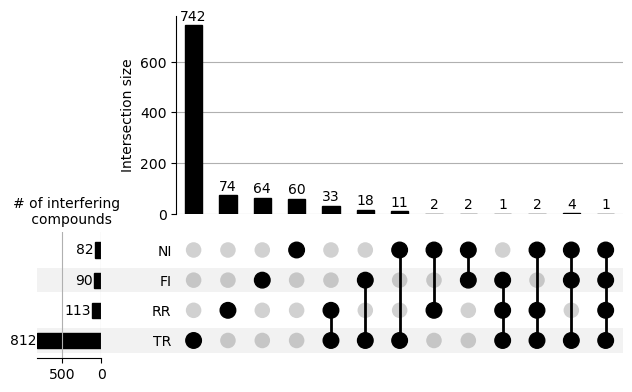

In [10]:
# Compute interfering compounds intersection.
labels_intersection = train_merged.T.dot(train_merged)
labels_intersection

# List contents of each category.
def list_contents(labels):
    contents_dict = {col: [] for col in labels.columns}
    for col in tqdm(labels.columns):
        data = labels[col]
        contents_dict[col] = data[data == 1].index.tolist()
    
    return from_contents(contents_dict)

categories = list_contents(train_merged)

# Plot overlap of interfering compounds.
ax_dict = UpSet(categories, subset_size="count", show_counts=True).plot();
ax_dict['totals'].set_title('# of interfering \n compounds' , fontsize=10)

100%|██████████| 4/4 [00:00<00:00, 8208.03it/s]


Text(0.5, 1.0, '# of interfering \n compounds')

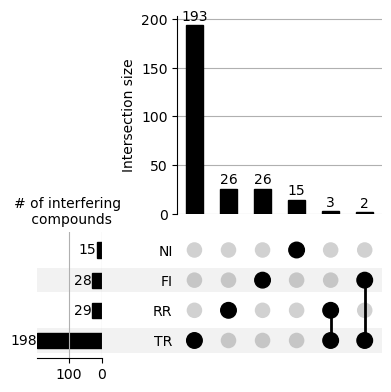

In [11]:
# Compute interfering compounds intersection.
labels_intersection = test_merged.T.dot(test_merged)
labels_intersection

# List contents of each category.
def list_contents(labels):
    contents_dict = {col: [] for col in labels.columns}
    for col in tqdm(labels.columns):
        data = labels[col]
        contents_dict[col] = data[data == 1].index.tolist()
    
    return from_contents(contents_dict)

categories = list_contents(test_merged)

# Plot overlap of interfering compounds.
ax_dict = UpSet(categories, subset_size="count", show_counts=True).plot();
ax_dict['totals'].set_title('# of interfering \n compounds' , fontsize=10)

In [12]:
train_dataset[i][i].value_counts()

KeyError: 'chembl.npy'

In [13]:
# print lenght of each dataset
for i in train_dataset.keys():
    print(i, train_dataset[i].dropna()[i].value_counts())
    print(i, test_dataset[i].dropna()[i].value_counts())
    print((test_dataset[i].dropna()[i].value_counts().sum() / train_dataset[i].dropna()[i].value_counts().sum()) * 100)

FI FI
0    3834
1      90
Name: count, dtype: int64
FI FI
0    953
1     28
Name: count, dtype: int64
25.0
NI NI
0    3836
1      82
Name: count, dtype: int64
NI NI
0    965
1     15
Name: count, dtype: int64
25.01276161306789
RR RR
0    3781
1     113
Name: count, dtype: int64
RR RR
0    945
1     29
Name: count, dtype: int64
25.012840267077557
TR TR
0    3035
1     811
Name: count, dtype: int64
TR TR
0    764
1    198
Name: count, dtype: int64
25.0130005200208


In [14]:
train_merged["TR"][4931] = None

In [15]:
# Merge dataframes.
merged = pd.concat([train_merged, test_merged], axis=0)
merged.reset_index(drop=True, inplace=True)

100%|██████████| 4/4 [00:00<00:00, 6477.69it/s]


Text(0.5, 1.0, '# interference \n compounds')

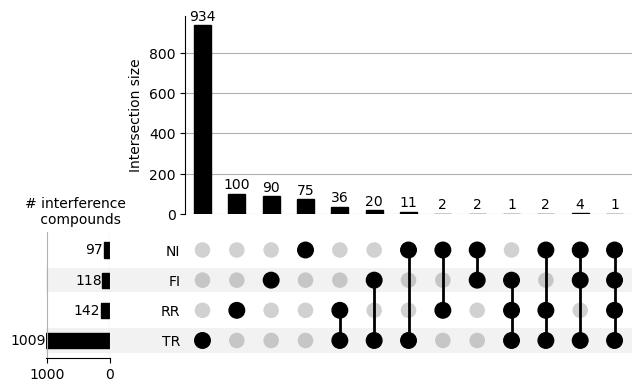

In [17]:
# Compute interfering compounds intersection.
labels_intersection = merged.T.dot(merged)
labels_intersection

# List contents of each category.
def list_contents(labels):
    contents_dict = {col: [] for col in labels.columns}
    for col in tqdm(labels.columns):
        data = labels[col]
        contents_dict[col] = data[data == 1].index.tolist()
    
    return from_contents(contents_dict)

categories = list_contents(merged)

# Plot overlap of interfering compounds.
ax_dict = UpSet(categories, subset_size="count", show_counts=True).plot();
ax_dict['totals'].set_title('# interference \n compounds' , fontsize=10)